### COINTEGRATION TEST: SP vs NQ

# Strategy Description: Adaptive Volatility Spread Strategy (SP vs. NQ)

### 1. Executive Summary
This strategy employs a **Statistical Arbitrage** approach, specifically focusing on the mean-reverting relationship between the S&P 500 (SP) and NASDAQ (NQ) futures.

The defining feature of this strategy is its **Adaptive Threshold Mechanism**. Recognizing that the NASDAQ (NQ) exhibits　higher and more variable volatility than the S&P 500, this strategy dynamically adjusts entry barriers based on the current volatility regime. By widening entry thresholds during high-volatility periods, the strategy avoids "noise" trades and targets larger mean-reversion opportunities that are sufficient to cover transaction costs.

### 2. Investment Universe & Specifications
* **Asset A (Independent Variable):** S&P 500 Futures (SP)
    * Point Value: $50
    * Transaction Cost: $12 per trade
* **Asset B (Dependent Variable):** NASDAQ Futures (NQ)
    * Point Value: $20
    * Transaction Cost: $12 per trade
* **Data Frequency:** 1-minute bars (Intraday)

### 3. Methodology

#### A. Dynamic Beta Calculation (Hedge Ratio)
To neutralize market exposure and isolate the spread, the strategy calculates a dynamic Hedge Ratio ($\beta$) based on the log-prices of the assets.
* **Formula:** $\ln(Price_{NQ}) = \alpha + \beta \times \ln(Price_{SP}) + \epsilon$
* **Window:** A long-term rolling window of **3,900 bars** (approx. 10 trading days) is used to capture the structural correlation while filtering out short-term fluctuations.

#### B. Adaptive Threshold Mechanism -> Advantages of this strategy!!
[Rationale] NQ volatility is the primary driver of spread expansion. During high volatility regimes, fixed Z-score thresholds often lead to premature entries (catching a falling knife) or "whipsaw" losses due to transaction costs.
The strategy calculates an **Adaptive Entry Threshold** using the following logic:
1.  **Volatility Ratio:** $\frac{\text{Current NQ Volatility (180 min)}}{\text{Baseline NQ Volatility (3900 min)}}$
2.  **Threshold Adjustment:**
    $$Z_{entry} = Z_{base} + \max(0, (VolRatio - 1.0) \times Sensitivity)$$
    * *Base Z:* 1.8
    * *Sensitivity:* 0.5 (For every 100% increase in relative volatility, the entry requirement increases by 0.5 sigma).

#### C. Z-Score Construction
The spread is defined as the residual of the log-price relationship. To standardize signals, a Z-Score is calculated:
* **Spread:** $\ln(NQ) - \beta_{lag} \times \ln(SP)$
* **Z-Score Window:** 390 bars (approx. 1 trading day).
* **Formula:** $Z = \frac{Spread - \mu_{spread}}{\sigma_{spread}}$

### 4. Trading Logic

The strategy operates as a Mean Reversion model with strict intraday time constraints.

* **Time Constraints:**
    * **Trading Window:** 09:56 – 15:40 CET.
    * **Forced Exit:** All positions are strictly closed at 15:40 CET (No overnight risk).

* **Entry Signals (Adaptive):**
    * **Short Spread:** If $Z > AdaptiveThreshold$ $\rightarrow$ **Sell NQ / Buy SP**.
    * **Long Spread:** If $Z < -AdaptiveThreshold$ $\rightarrow$ **Buy NQ / Sell SP**.
    * *Note:* Trades are executed with a 1:1 unit ratio (1 unit of NQ vs 1 unit of SP) to comply with project constraints, utilizing the signal derived from the dynamic beta model.

* **Exit Signals (Mean Reversion):**
    * Positions are closed when the spread reverts to the mean ($Z$ crosses 0.0) or at the daily forced exit time.

### 5. Risk Management
* **Volatility Filtering:** The adaptive mechanism inherently acts as a risk filter. By raising the entry bar during turbulent markets, the strategy avoids entering positions during momentum spikes, effectively waiting for "extreme" statistical anomalies.
* **Intraday Risk Control:** The strict 15:40 exit rule eliminates overnight gap risk and ensures the strategy focuses solely on intraday co-movements.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings('ignore')


### COINTEGRATION TEST: SP vs NQ
# ==========================================
# 1. Configuration & Data Loading
# ==========================================
class Config:
    FILE_PATH = '../../preprocess/df_g1_processed.pkl'  # ファイルパスを確認してください
    ASSETS = ['SP', 'NQ']


def load_insample_data(cfg):
    try:
        df = pd.read_pickle(cfg.FILE_PATH)
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    if 'NP' in df.columns: df.rename(columns={'NP': 'SP'}, inplace=True)

    # In-Sample期間のみを使用
    if 'Is_In_Sample' in df.columns:
        df = df[df['Is_In_Sample'] == True]

    # 欠損除去
    df = df[['SP', 'NQ']].dropna()
    return df


# ==========================================
# 2. Cointegration Analysis Function
# ==========================================
def analyze_pair_relationship(df):
    results = {}

    # 1. Log Transformation
    y = np.log(df['NQ'])
    x = np.log(df['SP'])

    # 2. Correlation
    corr = x.corr(y)
    results['Correlation'] = corr

    # 3. OLS Regression
    x_const = sm.add_constant(x)
    model = sm.OLS(y, x_const).fit()

    alpha = model.params['const']
    beta = model.params['SP']
    r_squared = model.rsquared

    results['Alpha'] = alpha
    results['Beta (Hedge Ratio)'] = beta
    results['R-Squared'] = r_squared

    # 4. Calculate Spread
    spread = y - (beta * x)

    # 5. ADF Test
    adf_result = adfuller(spread)

    results['ADF Statistic'] = adf_result[0]
    results['P-Value'] = adf_result[1]

    return results, spread, model


# ==========================================
# 3. Execution (Cointegration Check)
# ==========================================
if __name__ == "__main__":
    cfg = Config()
    df_train = load_insample_data(cfg)

    if df_train is not None and not df_train.empty:
        print(f"Analyzing In-Sample Data: {len(df_train)} bars")

        stats, spread_series, model = analyze_pair_relationship(df_train)

        print("\n" + "=" * 50)
        print(" COINTEGRATION TEST REPORT (SP vs NQ)")
        print("=" * 50)
        print(f"Correlation:       {stats['Correlation']:.4f}")
        print(f"R-Squared:         {stats['R-Squared']:.4f}")
        print(f"Hedge Ratio (Beta):{stats['Beta (Hedge Ratio)']:.4f}")
        print("-" * 30)
        print(f"ADF Statistic:     {stats['ADF Statistic']:.4f}")
        print(f"P-Value:           {stats['P-Value']:.6f}")
        print("-" * 30)

        if stats['P-Value'] < 0.05:
            print(">> RESULT: STATIONARY (Cointegrated) ✅")
        else:
            print(">> RESULT: NON-STATIONARY (Not Cointegrated) ❌")




Analyzing In-Sample Data: 170918 bars

 COINTEGRATION TEST REPORT (SP vs NQ)
Correlation:       0.9819
R-Squared:         0.9640
Hedge Ratio (Beta):1.2841
------------------------------
ADF Statistic:     -3.0089
P-Value:           0.034071
------------------------------
>> RESULT: STATIONARY (Cointegrated) ✅
Repairing Trading Flags (Auto-Detect Timezone)...


AttributeError: 'Index' object has no attribute 'mode'

Repairing Trading Flags: 956 - 1540 (CET)...
Calculating Adaptive Indicators & Dynamic Beta...
Data ready: 116438 rows
Simulating Adaptive Volatility Strategy...
Total Trades Executed: 1794.0
Average Entry Z-Score Used: 2.00

 PERFORMANCE REPORT: Adaptive Band Strategy (SP/NQ)
Quarter  Gross SR    Net SR  Ann. Vol ($)  Gross CR    Net CR  Gross CumP&L  Net CumP&L  Trades      Stat
2023_Q1  5.215490  4.072126  17665.910261  5.215490 17.482657      23981.92    18269.92   238.0 10.377940
2023_Q3  4.298415  3.072337  20311.539543  4.298415  8.893866      22520.61    15848.61   278.0  7.107579
2023_Q4  1.202106 -0.257838  16289.514660  1.202106 -0.538544       5125.32    -1066.68   258.0 -0.048919
2024_Q2 -0.948039 -2.239983  20191.534580 -0.948039 -2.444699      -5042.13   -11666.13   276.0 -6.731288
2024_Q4  3.510750  2.370309  18184.763734  3.510750  7.073757      16733.97    11117.97   234.0  4.504757
2025_Q1  0.337588 -0.929322  15686.875277  0.337588 -1.213980       1347.46    -3644.5

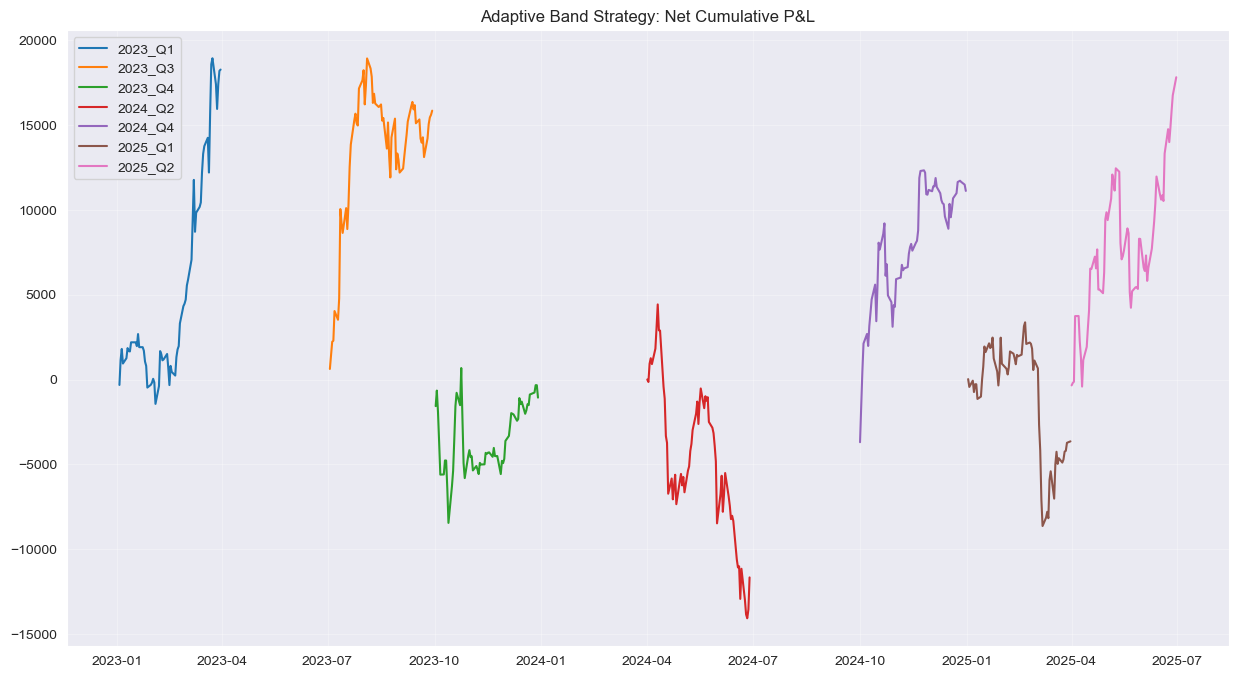

In [15]:
### GROUP 1 SP/NQ SPREAD STRATEGY (FIXED TIMEZONE)
# ==========================================
# 1. Configuration
# ==========================================
class Config:
    FILE_PATH = '../../preprocess/df_g1_processed.pkl'
    ASSETS = ['SP', 'NQ']

    SPECS = {
        'SP': {'point_val': 50.0, 'cost': 12.0},
        'NQ': {'point_val': 20.0, 'cost': 12.0}
    }


    # === Trading Hours (CET, FIXED) ===
    TRADE_START_HHMM = 956   # 09:56 CET
    TRADE_END_HHMM   = 1540  # 15:40 CET
    EXIT_HHMM        = 1540  # Forced exit

    # Parameters
    WINDOW = 120
    BETA_WINDOW = 600

    # Adaptive Settings
    VOL_WINDOW = 180
    VOL_BASELINE_WINDOW = 600
    BASE_Z_ENTRY = 2.0
    Z_EXIT = 0.5
    ADAPTIVE_SENSITIVITY = 0.5
    MAX_Z_ENTRY = 3.5
    ANNUALIZATION = 252


# ==========================================
# 2. Data Preparation (FIXED: Simple & Correct Timing)
# ==========================================
def prepare_spread_data(file_path, cfg):
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

    if 'NP' in df.columns and 'SP' not in df.columns:
        df.rename(columns={'NP': 'SP'}, inplace=True)

    # -----------------------------------------------------------
    # 1. Repair Flags (Use Config Hours Directly)
    # -----------------------------------------------------------
    print(f"Repairing Trading Flags: {cfg.TRADE_START_HHMM} - {cfg.EXIT_HHMM} (CET)...")

    # 余計な変換や判定をせず、データの時刻(CET)に対してルール時刻をそのまま適用
    hhmm = df.index.hour * 100 + df.index.minute

    # Trading Window
    df['can_trade'] = (hhmm >= cfg.TRADE_START_HHMM) & (hhmm <= cfg.TRADE_END_HHMM)

    # Forced Exit
    df['force_exit'] = (hhmm == cfg.EXIT_HHMM)

    # -----------------------------------------------------------

    req_cols = cfg.ASSETS + ['Quarter_ID', 'can_trade', 'force_exit']
    if not all(col in df.columns for col in req_cols):
        print(f"Error: Missing columns. Required: {req_cols}")
        return None

    data = df.copy()
    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print("Calculating Adaptive Indicators & Dynamic Beta...")

    def calc_metrics(group):
        ln_sp = np.log(group['SP'])
        ln_nq = np.log(group['NQ'])

        nq_ret = ln_nq.diff()

        # Volatility logic
        current_vol = nq_ret.rolling(window=cfg.VOL_WINDOW).std()
        baseline_vol = nq_ret.rolling(window=cfg.VOL_BASELINE_WINDOW).std()

        # Avoid division by zero
        vol_ratio = current_vol / baseline_vol.replace(0, np.nan)
        vol_ratio = vol_ratio.fillna(1.0)

        # Dynamic Beta
        cov = ln_nq.rolling(window=cfg.BETA_WINDOW).cov(ln_sp)
        var = ln_sp.rolling(window=cfg.BETA_WINDOW).var()
        beta = cov / var
        beta_lag = beta.shift(1).fillna(1.0)

        spread = ln_nq - (beta_lag * ln_sp)

        # Z-Score
        spread_mean = spread.rolling(window=cfg.WINDOW).mean()
        spread_std = spread.rolling(window=cfg.WINDOW).std()

        # Avoid division by zero
        spread_std = spread_std.replace(0, np.nan)

        z_score = (spread - spread_mean) / spread_std

        group['Z_Score'] = z_score
        group['Vol_Ratio'] = vol_ratio

        return group

    # group_keys=False to avoid MultiIndex issues
    data = calc_metrics(data)

    # Drop NaNs but ensure we don't drop everything
    data.dropna(subset=['Z_Score', 'Vol_Ratio'], inplace=True)

    print(f"Data ready: {len(data)} rows")
    return data


# ==========================================
# 3. Strategy Logic
# ==========================================
def run_spread_strategy(df, cfg):
    data = df.copy()

    z_scores = data['Z_Score'].values
    vol_ratios = data['Vol_Ratio'].values
    can_trade = data['can_trade'].values
    force_exit = data['force_exit'].values

    pos_spread = np.zeros(len(data), dtype=int)
    curr_pos = 0
    entry_thresholds_log = []

    print(f"Simulating Adaptive Volatility Strategy...")

    for i in range(len(data)):
        # Record Threshold
        if not np.isnan(vol_ratios[i]):
            extra_threshold = max(0, (vol_ratios[i] - 1.0) * cfg.ADAPTIVE_SENSITIVITY)
        else:
            extra_threshold = 0

        current_entry_z = min(cfg.BASE_Z_ENTRY + extra_threshold, cfg.MAX_Z_ENTRY)
        entry_thresholds_log.append(current_entry_z)

        # Priority 1: Force Exit
        if force_exit[i]:
            curr_pos = 0
            pos_spread[i] = 0
            continue

        # Priority 2: Can Trade?
        if not can_trade[i]:
            curr_pos = 0
            pos_spread[i] = 0
            continue

        z = z_scores[i]

        if np.isnan(z):
            pos_spread[i] = curr_pos
            continue

        # Trading Logic
        if curr_pos == 0:
            if z > current_entry_z:
                curr_pos = -1  # Sell Spread
            elif z < -current_entry_z:
                curr_pos = 1  # Buy Spread

        elif curr_pos == 1:
            if z >= cfg.Z_EXIT:
                curr_pos = 0

        elif curr_pos == -1:
            if z <= -cfg.Z_EXIT:
                curr_pos = 0

        pos_spread[i] = curr_pos

    data['Pos_Spread'] = pd.Series(pos_spread, index=data.index).shift(1).fillna(0)
    data['Dynamic_Threshold'] = entry_thresholds_log

    n_trades = data['Pos_Spread'].diff().abs().sum()
    avg_thresh = np.nanmean(entry_thresholds_log)
    print(f"Total Trades Executed: {n_trades}")
    print(f"Average Entry Z-Score Used: {avg_thresh:.2f}")

    return data


# ==========================================
# 4. P&L Calculation & Metrics
# ==========================================
def calculate_metrics(data, cfg):
    df = data.copy()

    df['dPrice_SP'] = df['SP'].diff()
    df['dPrice_NQ'] = df['NQ'].diff()

    # Gross PnL
    df['PnL_NQ'] = df['Pos_Spread'] * df['dPrice_NQ'] * cfg.SPECS['NQ']['point_val']
    df['PnL_SP'] = (df['Pos_Spread'] * -1) * df['dPrice_SP'] * cfg.SPECS['SP']['point_val']
    df['Gross_PnL_Total'] = df['PnL_NQ'] + df['PnL_SP']

    # Cost
    df['Trades_Spread'] = df['Pos_Spread'].diff().abs().fillna(0)
    cost_per_spread = cfg.SPECS['SP']['cost'] + cfg.SPECS['NQ']['cost']
    df['Cost_Total'] = df['Trades_Spread'] * cost_per_spread

    # Net PnL
    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']

    # Daily Aggregation
    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Trades_Spread': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


# ==========================================
# 5. Reporting
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    if daily_df.empty: return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()
        if len(d_q) == 0: continue

        gross_cum = d_q['Gross_PnL_Total'].sum()
        net_cum = d_q['Net_PnL_Total'].sum()

        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (d_q['Net_PnL_Total'].mean() / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        cum_ser = d_q['Net_PnL_Total'].cumsum()
        max_dd = (cum_ser.cummax() - cum_ser).max()
        years = len(d_q) / cfg.ANNUALIZATION
        net_cr = (net_cum / years / max_dd) if max_dd > 0 else 0

        abs_pnl_scaled = abs(net_cum) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        stat = (net_sr - 0.5) * max(0, log_term)

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': std_n * np.sqrt(cfg.ANNUALIZATION),
            'Gross CR': 0.0 if np.isnan(gross_sr) else gross_sr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum,
            'Net CumP&L': net_cum,
            'Trades': d_q['Trades_Spread'].sum(),
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty: return
    quarters = sorted(daily_stats['Quarter_ID'].unique())
    plt.figure(figsize=(15, 8))
    for q in quarters:
        d_q = daily_stats[daily_stats['Quarter_ID'] == q]
        plt.plot(d_q.index, d_q['Net_PnL_Total'].cumsum(), label=q)
    plt.title('Adaptive Band Strategy: Net Cumulative P&L')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# ==========================================
# 6. Main Execution
# ==========================================
if __name__ == "__main__":
    cfg = Config()

    df_prep = prepare_spread_data(cfg.FILE_PATH, cfg)

    if df_prep is not None:
        df_res = run_spread_strategy(df_prep, cfg)
        daily_data = calculate_metrics(df_res, cfg)
        stats_table = generate_quarterly_stats(daily_data, cfg)

        print("\n" + "=" * 80)
        print(" PERFORMANCE REPORT: Adaptive Band Strategy (SP/NQ)")
        print("=" * 80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()

            # Simple aggregation for display
            print(stats_table.to_string(index=False))
            print("\n" + "=" * 40)
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print("=" * 40)

            plot_equity_curve(daily_data)
        else:
            print("No trades generated.")